In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pickle
from shapely.geometry import shape, Point
import rasterio.features
from osgeo import gdal, osr
from shapely.wkt import loads

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import the KDE pickle file
with open('../Outputs/KDE_output_200m.pickle', 'rb') as f:
    kde_200 = pickle.load(f)

kde_200.shape

(2500, 2500)

In [5]:
#import brooklyn's boundary shape
bk_bndry = gpd.read_file('../Data/BrooklynBoundary.shp')
bk_bndry = bk_bndry.to_crs(32618)
bk_bndry.head()

,FID,geometry
0,0,"MULTIPOLYGON (((584478.960 4491458.524, 584470..."


In [48]:
#import tracts
nyc_tracts = pd.read_csv('../Data/2020_Census_Tracts_-_Tabular.csv')
nyc_tracts['the_geom'] = nyc_tracts['the_geom'].apply(loads)

# Convert the pandas DataFrame to a GeoDataFrame
tracts_gdf = gpd.GeoDataFrame(nyc_tracts, geometry='the_geom', crs = '4326')
tracts_gdf = tracts_gdf.to_crs(32618)
bk_tracts = tracts_gdf[tracts_gdf['BoroName'] == 'Brooklyn'].reset_index(drop = True)
bk_tracts.head()

,the_geom,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,Shape_Leng,Shape_Area
0,"MULTIPOLYGON (((585247.472 4506029.684, 585252...",1.00,3,Brooklyn,100,3000100,NaN,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000100,6611.443960,2.224101e+06
1,"MULTIPOLYGON (((584007.655 4500982.266, 583958...",2.00,3,Brooklyn,200,3000200,NaN,Sunset Park (West),BK0702,BK07,BK07 Sunset Park-Windsor Terrace (CD 7 Approxi...,36047000200,9075.285121,2.952085e+06
2,"MULTIPOLYGON (((584966.437 4505778.759, 584940...",3.01,3,Brooklyn,301,3000301,NaN,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000301,6525.111338,2.164337e+06
3,"MULTIPOLYGON (((585075.427 4505660.913, 585012...",5.01,3,Brooklyn,501,3000501,NaN,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000501,4828.170276,9.015070e+05
4,"MULTIPOLYGON (((585215.411 4505612.714, 585223...",5.02,3,Brooklyn,502,3000502,NaN,Brooklyn Heights,BK0201,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,36047000502,4902.479685,1.041529e+06


In [8]:
output_raster_path = '../Outputs/KDE_200m_raster_output.tif'

In [9]:
#convert to raster to use with geo shape files
# Define the minimum and maximum bounds of the raster
#change this to the bk boundary shapefile
min_x, min_y, max_x, max_y = bk_bndry.total_bounds

width = 2500
height = 2500
pixel_width = (max_x - min_x) / width
pixel_height = (max_y - min_y) / height
#define spatial reference
srs = osr.SpatialReference()
srs.ImportFromEPSG(32618) 
#create raster
driver = gdal.GetDriverByName('GTiff')
output_raster = driver.Create(output_raster_path, width, height, 1, gdal.GDT_Float32)

# Set the raster's geotransform (georeferencing information)
output_raster.SetGeoTransform((min_x, pixel_width, 0, max_y, 0, -pixel_height))

# Set the raster's spatial reference system (SRS)
if srs is not None:
    output_raster.SetProjection(srs.ExportToWkt())

# Write the array data to the raster
band = output_raster.GetRasterBand(1)
band.WriteArray(kde_200)

# Save and close the raster file
output_raster.FlushCache()
output_raster = None

In [31]:
x_grid, y_grid = np.meshgrid(np.linspace(min_x, max_x,2500),
                             np.linspace(min_y, max_y, 2500))
levels = np.linspace(0, kde_200.max(), 25)

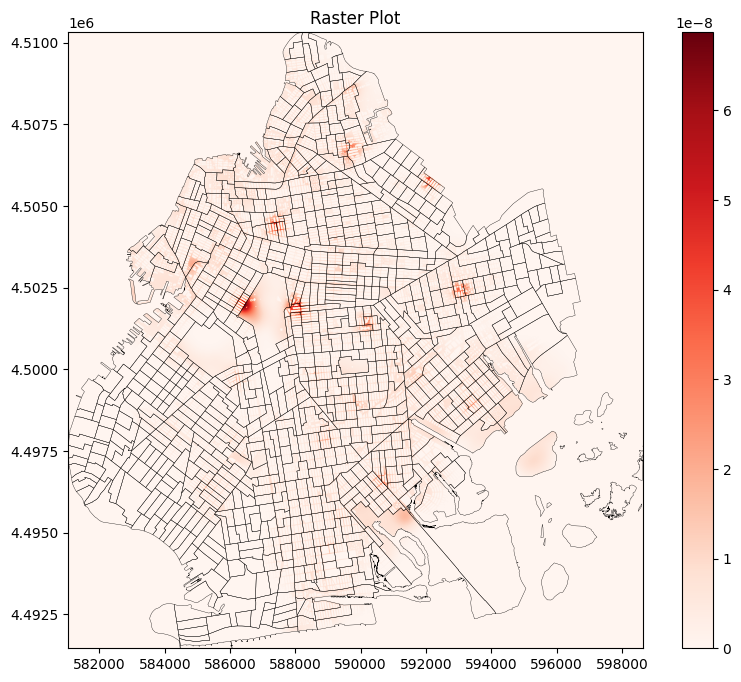

In [54]:
#check output
# Open the saved raster file
with rasterio.open(output_raster_path) as src:
    raster_array = src.read(1)

# Plot the raster array
fig, ax = plt.subplots(figsize=(10, 8))
raster_image = ax.imshow(raster_array, cmap='Reds',extent=[min_x, max_x, min_y, max_y])
# Plot the bk_boundary geodataframe
bk_tracts.plot(ax=ax, facecolor='none', edgecolor='black',linewidth = 0.25)
fig.colorbar(raster_image, ax=ax)
ax.set_title('Raster Plot')
plt.show()

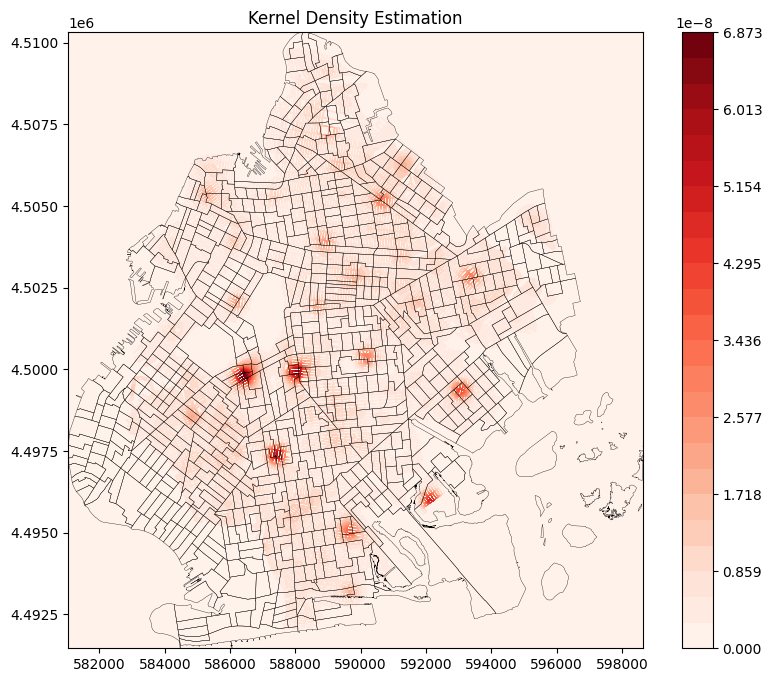

In [55]:
# Plot the array contour map
fig, ax = plt.subplots(figsize=(10, 8))
contour = ax.contourf(x_grid, y_grid, kde_200, levels=levels, cmap=plt.cm.Reds)
bk_tracts.plot(ax=ax, facecolor='none', edgecolor='black',linewidth = 0.25)
# Set title and color bar
ax.set_title('Kernel Density Estimation')
fig.colorbar(contour, ax=ax)